## 0. Environment Setup and Library Import
This section loads all the required libraries for dimensionality reduction, classification, visualization, and the autoencoder model implementation.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

## 1. Data Loading and Preprocessing
We load the Olivetti Faces dataset consisting of 400 grayscale facial images.
Stratified Train/Test Split (80:20) is used to preserve the equal number of samples per person in both training and testing sets.
All data is standardized (mean-centering and scaling) before applying PCA, LDA, or Autoencoder.

In [42]:
data = fetch_olivetti_faces()
X = data.images        # (400, 64, 64), float32, 0~1
y = data.target        # (400,), 0~39

print("X shape:", X.shape, "y shape:", y.shape)

# flatten
X_flat = X.reshape((X.shape[0], -1))  # (400, 4096)

# Train/Test stratified split
X_train_flat, X_test_flat, y_train, y_test, X_train_img, X_test_img = train_test_split(
    X_flat, y, X,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train:", X_train_flat.shape, "Test:", X_test_flat.shape)

# Standardization (with mean-centering)
scaler = StandardScaler()
X_train_flat_scaled = scaler.fit_transform(X_train_flat)
X_test_flat_scaled = scaler.transform(X_test_flat)

# Autoencoder: (N, 64, 64, 1)
X_train_ae = np.expand_dims(X_train_img, axis=-1)
X_test_ae = np.expand_dims(X_test_img, axis=-1)

print("AE train shape:", X_train_ae.shape, "AE test shape:", X_test_ae.shape)

X shape: (400, 64, 64) y shape: (400,)
Train: (320, 4096) Test: (80, 4096)
AE train shape: (320, 64, 64, 1) AE test shape: (80, 64, 64, 1)


## 2. Dimensionality Reduction using PCA and LDA
Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA) are trained on the training set.Both create a 32-dimensional feature representation to allow a fair comparison with the autoencoder.

In [43]:
PCA_DIM = 32
LDA_DIM = 32  # cf. LDA MAX = 39

# PCA
pca = PCA(n_components=PCA_DIM, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_flat_scaled)
X_test_pca = pca.transform(X_test_flat_scaled)

print("PCA train:", X_train_pca.shape, "PCA test:", X_test_pca.shape)

# LDA
lda = LDA(n_components=LDA_DIM)
X_train_lda = lda.fit_transform(X_train_flat_scaled, y_train)
X_test_lda = lda.transform(X_test_flat_scaled)

print("LDA train:", X_train_lda.shape, "LDA test:", X_test_lda.shape)

PCA train: (320, 32) PCA test: (80, 32)
LDA train: (320, 32) LDA test: (80, 32)


## 3. Autoencoder Architecture Definition
A convolutional autoencoder is built to learn a nonlinear low-dimensional latent space (32-D).
The encoder compresses the input image, and the decoder reconstructs the original resolution.

In [44]:
# Autoencoder(Conv)
LATENT_DIM = 32
INPUT_SHAPE = (64, 64, 1)

def build_autoencoder(input_shape=INPUT_SHAPE, latent_dim=LATENT_DIM):
    # Encoder
    encoder_inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(encoder_inputs)
    x = layers.MaxPooling2D((2,2), padding="same")(x)   # 32x32
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2), padding="same")(x)   # 16x16
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2), padding="same")(x)   # 8x8
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    latent = layers.Dense(latent_dim, name="latent")(x)

    encoder = keras.Model(encoder_inputs, latent, name="encoder")

    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(8*8*64, activation="relu")(latent_inputs)
    x = layers.Reshape((8, 8, 64))(x)
    x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)  # 16x16
    x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)  # 32x32
    x = layers.Conv2DTranspose(16, (3,3), strides=2, activation="relu", padding="same")(x)  # 64x64
    decoder_outputs = layers.Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    # AE
    ae_inputs = encoder_inputs
    encoded = encoder(ae_inputs)
    decoded = decoder(encoded)

    autoencoder = keras.Model(ae_inputs, decoded, name="autoencoder")
    return encoder, decoder, autoencoder

encoder, decoder, autoencoder = build_autoencoder()

autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       551,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 64, 64, 1)      │       195,329 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 747,169 (2.85 MB)

 Trainable params: 747,169 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Autoencoder Training Procedure
The autoencoder is trained using mean squared error (MSE) reconstruction loss and the Adam optimizer.
Early stopping is applied to prevent overfitting by restoring the weights with the lowest validation loss.

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.0321 - val_loss: 0.0314
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0315 - val_loss: 0.0305
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0305 - val_loss: 0.0273
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0266 - val_loss: 0.0233
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0230 - val_loss: 0.0220
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0213 - val_loss: 0.0208
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0200 - val_loss: 0.0198
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0194 - val_loss: 0.0195
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0190 - val_loss: 0.0193
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0188 - val_loss: 0.0190
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0185 - val_loss: 0.0186
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0179 - val_l

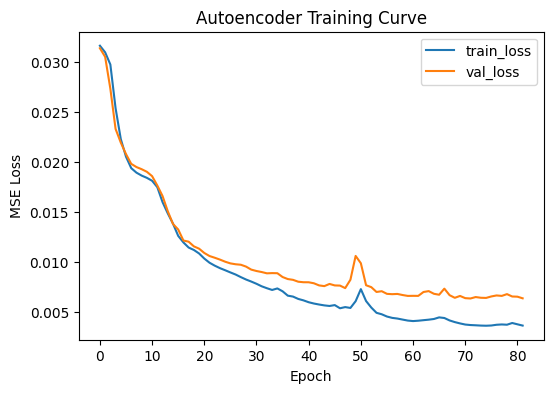

In [45]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(),
    loss="mse"
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# plot
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Autoencoder Training Curve")
plt.show()

## 5. Extraction of Latent Features
After training, the encoder network transforms training and testing images into 32-dimensional latent vectors for further evaluation.

In [46]:
# Autoencoder latent feature extraction
X_train_ae_latent = encoder.predict(X_train_ae)
X_test_ae_latent = encoder.predict(X_test_ae)

print("AE latent train:", X_train_ae_latent.shape, "AE latent test:", X_test_ae_latent.shape)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
AE latent train: (320, 32) AE latent test: (80, 32)


## 6. Visualization of Eigenfaces and Fisherfaces
For PCA, the principal components (Eigenfaces) are reshaped into 64×64 images and visualized to show global facial patterns.
For LDA, the discriminative directions (Fisherfaces) highlight facial regions useful for identity separation.

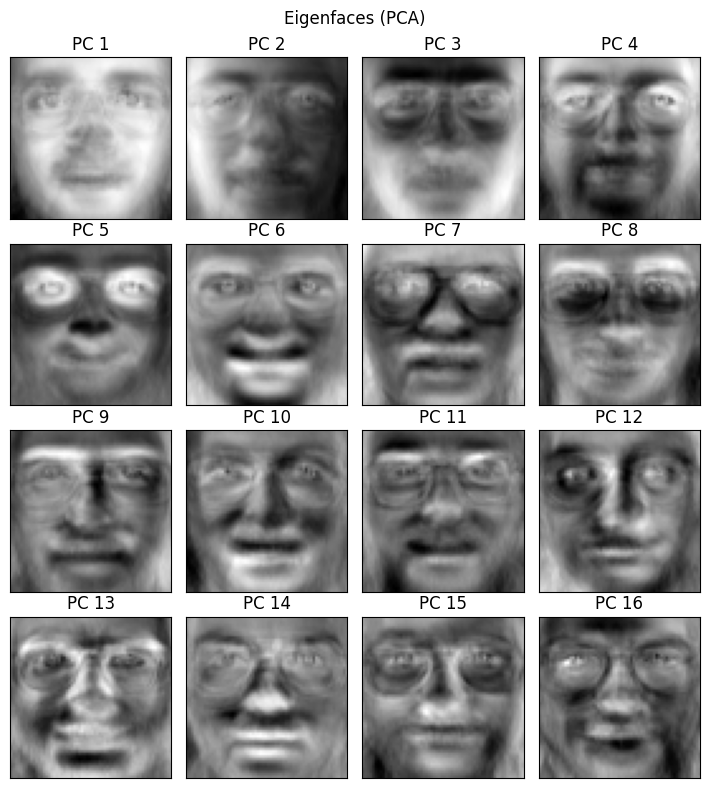

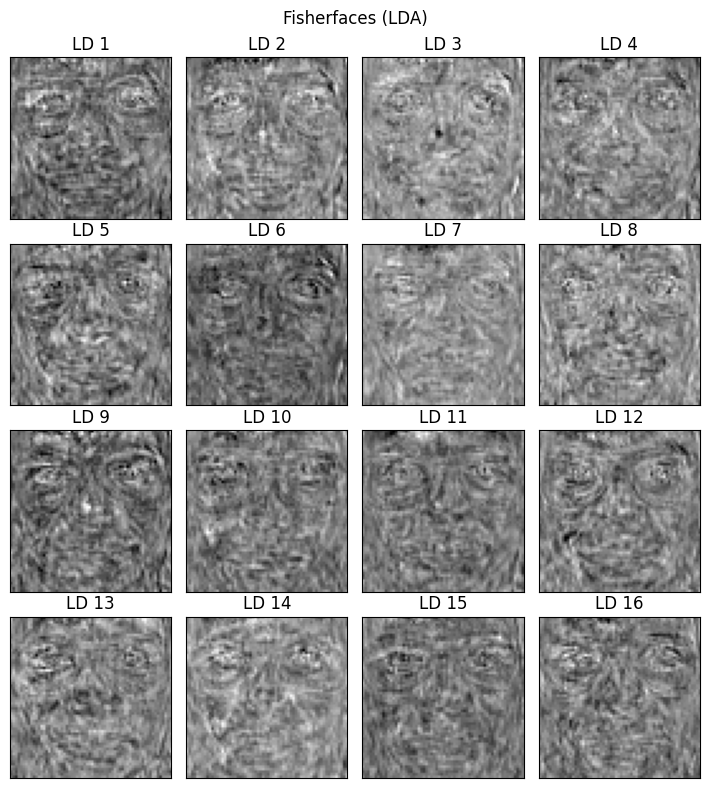

In [47]:
# Eigenfaces / Fisherfaces plot
def plot_eigenfaces(pca, h=64, w=64, n_components=16):
    components = pca.components_[:n_components]
    n_cols = 4
    n_rows = int(np.ceil(n_components / n_cols))
    plt.figure(figsize=(1.8*n_cols, 2.0*n_rows))
    for i, comp in enumerate(components):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(comp.reshape((h, w)), cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.title(f"PC {i+1}")
    plt.suptitle("Eigenfaces (PCA)")
    plt.tight_layout()
    plt.show()

def plot_fisherfaces(lda, h=64, w=64, n_components=16):
    if lda.scalings_ is None:
        print("LDA scalings_ is None, cannot plot Fisherfaces.")
        return
    # lda.scalings_: (n_features, n_components)
    vectors = lda.scalings_.T
    n_components = min(n_components, vectors.shape[0])
    n_cols = 4
    n_rows = int(np.ceil(n_components / n_cols))
    plt.figure(figsize=(1.8*n_cols, 2.0*n_rows))
    for i in range(n_components):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(vectors[i].reshape((h, w)), cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.title(f"LD {i+1}")
    plt.suptitle("Fisherfaces (LDA)")
    plt.tight_layout()
    plt.show()

plot_eigenfaces(pca, h=64, w=64, n_components=16)
plot_fisherfaces(lda, h=64, w=64, n_components=16)

## 7. Visualization of Autoencoder Latent Space
The latent features from the encoder are projected into 2D using t-SNE to visually observe identity-based clustering structures.

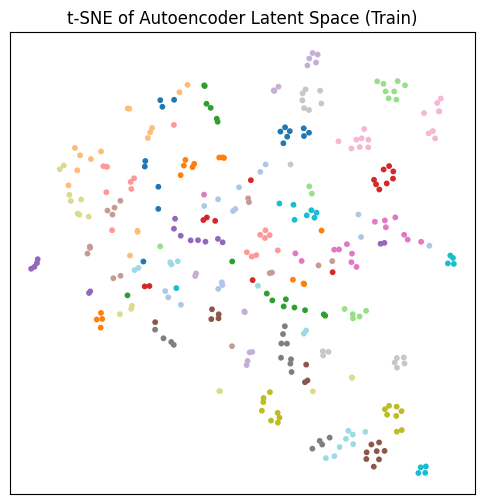

In [48]:
# Autoencoder latent space plotting via t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30)
X_ae_tsne = tsne.fit_transform(X_train_ae_latent)

plt.figure(figsize=(6,6))
scatter = plt.scatter(X_ae_tsne[:,0], X_ae_tsne[:,1], c=y_train, cmap="tab20", s=10)
plt.title("t-SNE of Autoencoder Latent Space (Train)")
plt.xticks([])
plt.yticks([])
plt.show()

## 8. Reconstruction Comparison
We compare reconstructed test images using PCA and Autoencoder.
In addition to visual comparison, mean squared error (MSE) is computed to evaluate reconstruction quality numerically.

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 363ms/step


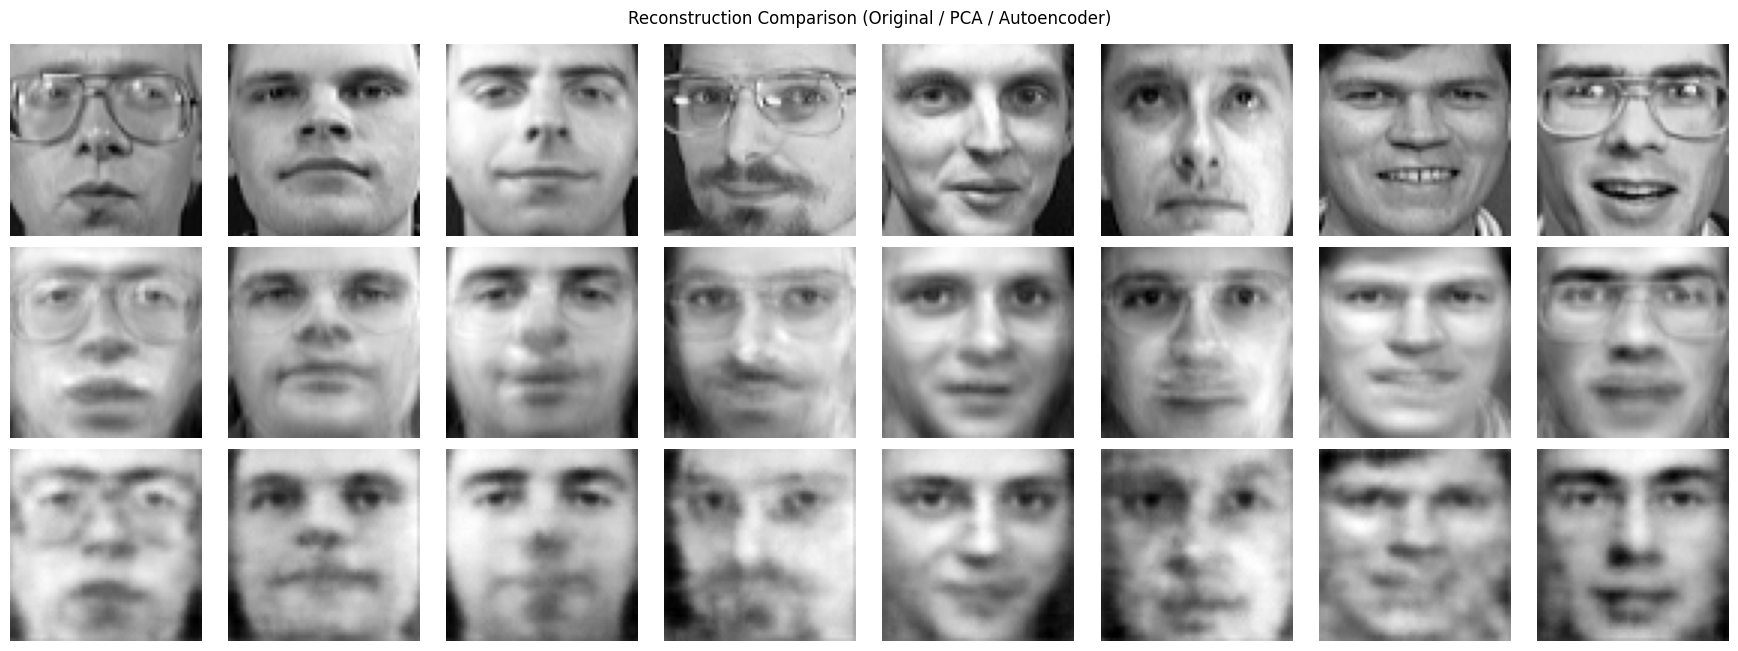

Reconstruction MSE - PCA: 0.0040855868719518185
Reconstruction MSE - AE : 0.005482742562890053


In [49]:
# Original vs PCA vs Autoencoder

def reconstruct_pca(pca, X_flat_scaled):
    X_pca = pca.transform(X_flat_scaled)
    X_recon_scaled = pca.inverse_transform(X_pca)
    X_recon_flat = scaler.inverse_transform(X_recon_scaled)
    X_recon_flat = np.clip(X_recon_flat, 0.0, 1.0)
    X_recon_img = X_recon_flat.reshape((-1, 64, 64))
    return X_recon_img

# PCA reconstruct
X_test_pca_recon = reconstruct_pca(pca, X_test_flat_scaled)

# Autoencoder reconstruct
X_test_ae_recon = autoencoder.predict(X_test_ae)  # (N, 64,64,1)
X_test_ae_recon_img = X_test_ae_recon.squeeze(axis=-1)

# sampling
def plot_reconstructions(X_orig, X_pca_recon, X_ae_recon, n_samples=10):
    n_samples = min(n_samples, X_orig.shape[0])
    plt.figure(figsize=(n_samples*2.2, 3*2.2))
    for i in range(n_samples):
        # Original
        plt.subplot(3, n_samples, i+1)
        plt.imshow(X_orig[i], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=10)
        # PCA
        plt.subplot(3, n_samples, n_samples + i+1)
        plt.imshow(X_pca_recon[i], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("PCA", fontsize=10)
        # AE
        plt.subplot(3, n_samples, 2*n_samples + i+1)
        plt.imshow(X_ae_recon[i], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("AE", fontsize=10)
    plt.suptitle("Reconstruction Comparison (Original / PCA / Autoencoder)")
    plt.tight_layout()
    plt.show()

plot_reconstructions(X_test_img, X_test_pca_recon, X_test_ae_recon_img, n_samples=8)

# MSE
mse_pca = mean_squared_error(X_test_img.reshape(len(X_test_img), -1),
                             X_test_pca_recon.reshape(len(X_test_pca_recon), -1))
mse_ae = mean_squared_error(X_test_img.reshape(len(X_test_img), -1),
                            X_test_ae_recon_img.reshape(len(X_test_ae_recon_img), -1))
print("Reconstruction MSE - PCA:", mse_pca)
print("Reconstruction MSE - AE :", mse_ae)

## 9. Linear SVM Classification using Low-Dimensional Features
A Linear Support Vector Machine (SVM) is trained on each feature set (PCA, LDA, Autoencoder).
Test accuracy is measured to compare classification performance across dimensionality reduction techniques.

In [50]:
# SVM
svm_pca = SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE)
svm_lda = SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE)
svm_ae  = SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE)

# train
svm_pca.fit(X_train_pca, y_train)
svm_lda.fit(X_train_lda, y_train)
svm_ae.fit(X_train_ae_latent, y_train)

# predict
y_pred_pca = svm_pca.predict(X_test_pca)
y_pred_lda = svm_lda.predict(X_test_lda)
y_pred_ae  = svm_ae.predict(X_test_ae_latent)

# Accuracy
acc_pca = accuracy_score(y_test, y_pred_pca)
acc_lda = accuracy_score(y_test, y_pred_lda)
acc_ae  = accuracy_score(y_test, y_pred_ae)

print(f"PCA + SVM Accuracy: {acc_pca:.4f}")
print(f"LDA + SVM Accuracy: {acc_lda:.4f}")
print(f"AE  + SVM Accuracy: {acc_ae:.4f}")

PCA + SVM Accuracy: 0.9625
LDA + SVM Accuracy: 1.0000
AE  + SVM Accuracy: 0.9250


## 10. Visualization of Classification Accuracy
A bar plot illustrates the performance difference between PCA, LDA, and Autoencoder features when used for face recognition.

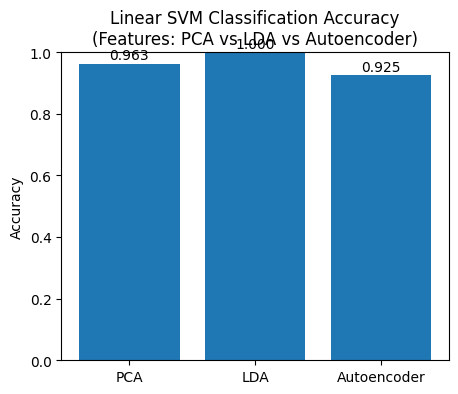

In [51]:
methods = ["PCA", "LDA", "Autoencoder"]
accs = [acc_pca, acc_lda, acc_ae]

plt.figure(figsize=(5,4))
bars = plt.bar(methods, accs)
for b, a in zip(bars, accs):
    plt.text(b.get_x() + b.get_width()/2, b.get_height() + 0.005,
             f"{a:.3f}", ha="center", va="bottom")
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.title("Linear SVM Classification Accuracy\n(Features: PCA vs LDA vs Autoencoder)")
plt.show()

## 11. Reconstruction Error Distribution (Additional Analysis)
Per-image reconstruction errors (MSE) are plotted as histograms
to compare reconstruction stability between PCA and Autoencoder.
This visualization helps determine whether nonlinear learning
provides more consistent reconstruction quality.

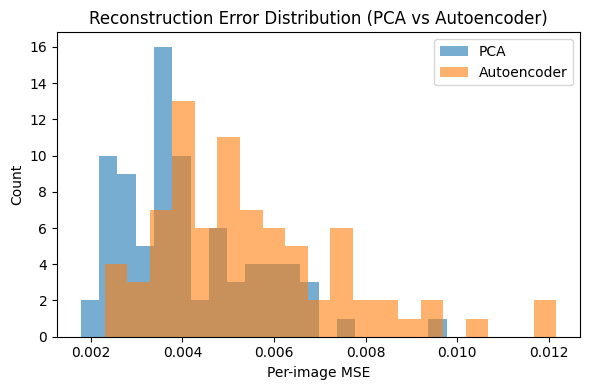

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Per-image MSE for PCA and Autoencoder
errors_pca = np.mean((X_test_img - X_test_pca_recon) ** 2, axis=(1, 2))
errors_ae = np.mean((X_test_img - X_test_ae_recon_img) ** 2, axis=(1, 2))

plt.figure(figsize=(6, 4))
plt.hist(errors_pca, bins=20, alpha=0.6, label="PCA")
plt.hist(errors_ae, bins=20, alpha=0.6, label="Autoencoder")
plt.xlabel("Per-image MSE")
plt.ylabel("Count")
plt.title("Reconstruction Error Distribution (PCA vs Autoencoder)")
plt.legend()
plt.tight_layout()
plt.show()

## 12. Effect of Latent Dimensionality on Accuracy (Additional Analysis)
SVM accuracy is evaluated using reduced latent dimensions (8, 16, 32).
A line graph reveals how dimensionality impacts recognition performance
in linear (PCA) and nonlinear (Autoencoder) settings.

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
dim = 8 | PCA acc = 0.8750, AE acc = 0.8500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
dim = 16 | PCA acc = 0.9250, AE acc = 0.9000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
dim = 32 | PCA acc = 0.9625, AE acc = 0.9375


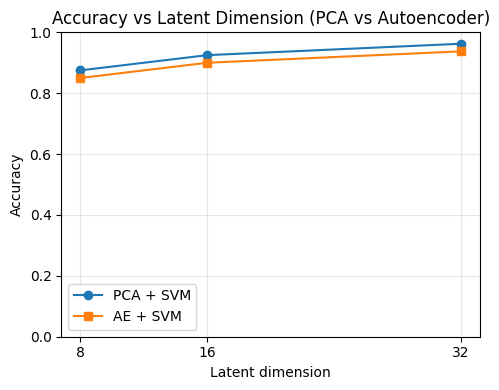

In [53]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dims = [8, 16, 32]
accs_pca_dim = []
accs_ae_dim = []

for d in dims:
    #  PCA
    pca_d = PCA(n_components=d, random_state=RANDOM_STATE)
    X_train_pca_d = pca_d.fit_transform(X_train_flat_scaled)
    X_test_pca_d = pca_d.transform(X_test_flat_scaled)

    svm_pca_d = SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE)
    svm_pca_d.fit(X_train_pca_d, y_train)
    y_pred_pca_d = svm_pca_d.predict(X_test_pca_d)
    acc_pca_d = accuracy_score(y_test, y_pred_pca_d)
    accs_pca_dim.append(acc_pca_d)

    # AE
    encoder_d, decoder_d, ae_d = build_autoencoder(latent_dim=d)
    ae_d.compile(optimizer=keras.optimizers.Adam(), loss="mse")

    early_stop_d = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    )

    ae_d.fit(
        X_train_ae, X_train_ae,
        epochs=80,
        batch_size=32,
        shuffle=True,
        validation_split=0.2,
        callbacks=[early_stop_d],
        verbose=0
    )

    X_train_ae_latent_d = encoder_d.predict(X_train_ae)
    X_test_ae_latent_d = encoder_d.predict(X_test_ae)

    svm_ae_d = SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE)
    svm_ae_d.fit(X_train_ae_latent_d, y_train)
    y_pred_ae_d = svm_ae_d.predict(X_test_ae_latent_d)
    acc_ae_d = accuracy_score(y_test, y_pred_ae_d)
    accs_ae_dim.append(acc_ae_d)

    print(f"dim = {d} | PCA acc = {acc_pca_d:.4f}, AE acc = {acc_ae_d:.4f}")

plt.figure(figsize=(5, 4))
plt.plot(dims, accs_pca_dim, marker="o", label="PCA + SVM")
plt.plot(dims, accs_ae_dim, marker="s", label="AE + SVM")
plt.xlabel("Latent dimension")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Latent Dimension (PCA vs Autoencoder)")
plt.xticks(dims)
plt.ylim(0, 1.0)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 13. Intra-class Distance vs Inter-class Distance
Pairwise Euclidean distances are measured in each feature space.
A grouped bar plot compares intra-class compactness and inter-class separation
for PCA, LDA, and Autoencoder features — indicating class discriminability.

PCA  intra: 45.76032 inter: 80.725105
LDA  intra: 7.6843653 inter: 24.242813
AE   intra: 10.387802 inter: 19.245115


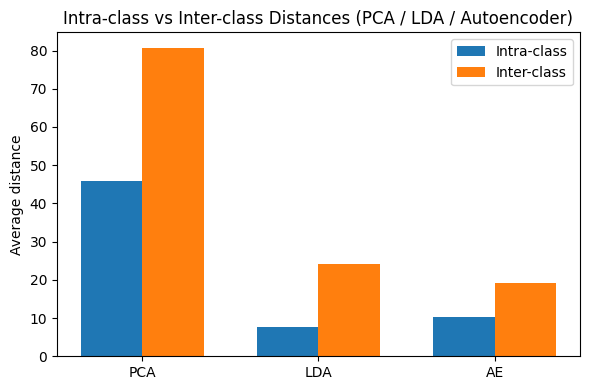

In [54]:
from sklearn.metrics import pairwise_distances
import numpy as np
import matplotlib.pyplot as plt

def compute_intra_inter_distances(features, labels):
    features = np.asarray(features)
    labels = np.asarray(labels)

    D = pairwise_distances(features, metric="euclidean")  # (N, N)
    same_mask = labels[:, None] == labels[None, :]
    diff_mask = ~same_mask

    # exclude diagonal from intra-class
    diag_mask = np.eye(len(labels), dtype=bool)
    intra = D[same_mask & ~diag_mask]
    inter = D[diff_mask]

    intra_mean = np.mean(intra)
    inter_mean = np.mean(inter)
    return intra_mean, inter_mean

intra_pca, inter_pca = compute_intra_inter_distances(X_train_pca, y_train)
intra_lda, inter_lda = compute_intra_inter_distances(X_train_lda, y_train)
intra_ae, inter_ae = compute_intra_inter_distances(X_train_ae_latent, y_train)

print("PCA  intra:", intra_pca, "inter:", inter_pca)
print("LDA  intra:", intra_lda, "inter:", inter_lda)
print("AE   intra:", intra_ae, "inter:", inter_ae)

methods = ["PCA", "LDA", "AE"]
intra_means = [intra_pca, intra_lda, intra_ae]
inter_means = [inter_pca, inter_lda, inter_ae]

x = np.arange(len(methods))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, intra_means, width, label="Intra-class")
plt.bar(x + width/2, inter_means, width, label="Inter-class")
plt.xticks(x, methods)
plt.ylabel("Average distance")
plt.title("Intra-class vs Inter-class Distances (PCA / LDA / Autoencoder)")
plt.legend()
plt.tight_layout()
plt.show()

jjyoon012@gmail.com